# Transfer learning


Reference:

Keras Documentation:  https://keras.io/applications/#usage-examples-for-image-classification-models

Transfer Learning Example : https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/



**Environment:**

- Python 3.6
- Keras-gpu 2.2.0
- matplotlib 2.2.2
- pillow 5.1.0


# Build a base model

In [2]:
from keras.applications.mobilenetv2 import MobileNetV2

from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


# create the base pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# keras.applications.mobilenet.MobileNet(input_shape=None, alpha=1.0, depth_multiplier=1, dropout=1e-3, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)

Using TensorFlow backend.


# Create a new model

In [3]:
# from keras import models
# from keras import layers
# from keras import optimizers
 
targetClassNumber = 11   
    
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(base_model)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(targetClassNumber, activation='softmax'))

# Freeze layers from pretrained model

In [4]:
# Freeze the layers except the last 4 layers
for layer in model.layers[:-4]:
    layer.trainable = False
 
# # Check the trainable status of the individual layers
# for layer in vgg_conv.layers:
#     print(layer, layer.trainable)

# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              64226304  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                11275     
Total params: 66,495,563
Trainable params: 64,237,579
Non-trainable params: 2,257,984
_________________________________________________________________


# Setup the data generators

In [5]:
train_dir = './train'
validation_dir = './validation'
image_size = 224
 
# nTrain = 600
# nVal = 150

# from keras.preprocessing.image import ImageDataGenerator
# import numpy as np
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 33
val_batchsize = 22
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 33 images belonging to 11 classes.
Found 22 images belonging to 11 classes.


# Save image labels

### as a pickle file to look up during prediction step

In [6]:
import pickle

# Label dictionary of train images
class_dictionary = train_generator.class_indices
print('Train Label Dictionary : \n',class_dictionary)

with open('labels.pickle', 'wb') as f:
    pickle.dump(class_dictionary, f)

Train Label Dictionary : 
 {'Benjamin': 0, 'Damarcus': 1, 'Frank': 2, 'Lokesh': 3, 'Misael': 4, 'Sohail': 5, 'aaron': 6, 'albert': 7, 'brian': 8, 'mooyoung-lee': 9, 'vivek': 10}


# Train the model


In [7]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
 
# Save the model
model.save('faceID_MobileNet2.h5')

Epoch 1/30
1/1 [==============================] - 28s 28s/step - loss: 4.5522 - acc: 0.0909 - val_loss: 6.0579 - val_acc: 0.2273
Epoch 2/30
1/1 [==============================] - 23s 23s/step - loss: 4.1356 - acc: 0.3636 - val_loss: 7.5733 - val_acc: 0.1818
Epoch 3/30
1/1 [==============================] - 23s 23s/step - loss: 6.3717 - acc: 0.4242 - val_loss: 6.5314 - val_acc: 0.3636
Epoch 4/30
1/1 [==============================] - 23s 23s/step - loss: 4.6596 - acc: 0.5758 - val_loss: 7.7693 - val_acc: 0.1818
Epoch 5/30
1/1 [==============================] - 24s 24s/step - loss: 4.1766 - acc: 0.6061 - val_loss: 7.3421 - val_acc: 0.2727
Epoch 6/30
1/1 [==============================] - 23s 23s/step - loss: 3.4886 - acc: 0.5152 - val_loss: 4.0794 - val_acc: 0.5000
Epoch 7/30
1/1 [==============================] - 23s 23s/step - loss: 1.7602 - acc: 0.7879 - val_loss: 4.2732 - val_acc: 0.4091
Epoch 8/30
1/1 [==============================] - 23s 23s/step - loss: 0.8669 - acc: 0.8182 - val

# Check Performance

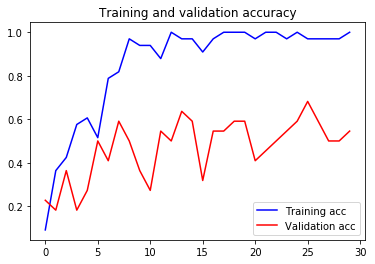

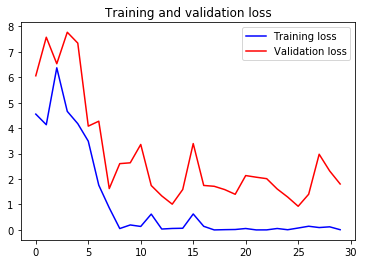

In [8]:
# %matplotlib inline
# import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Found 22 images belonging to 11 classes.
1/1 [==============================] - 10s 10s/step
No of errors = 10/22


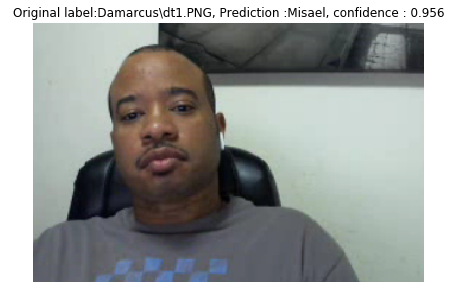

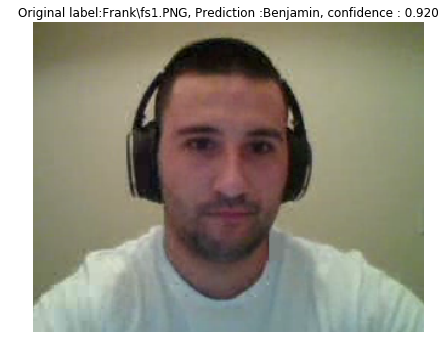

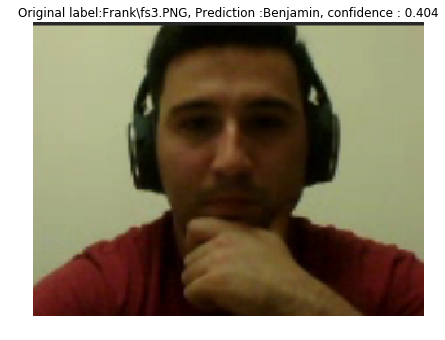

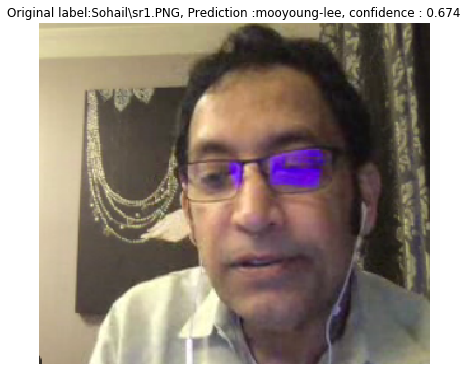

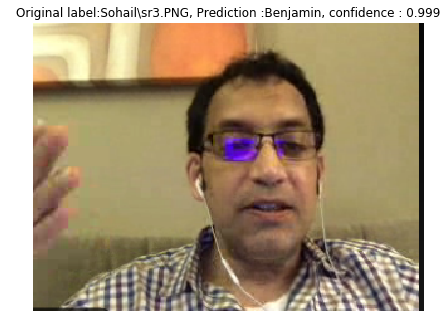

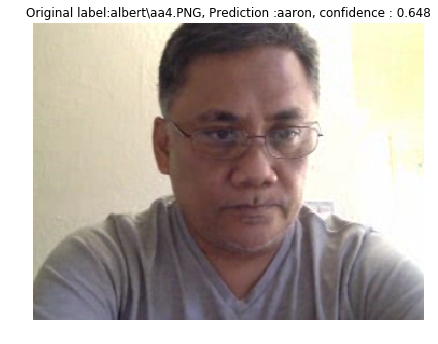

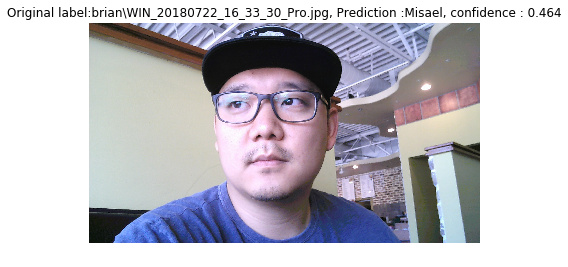

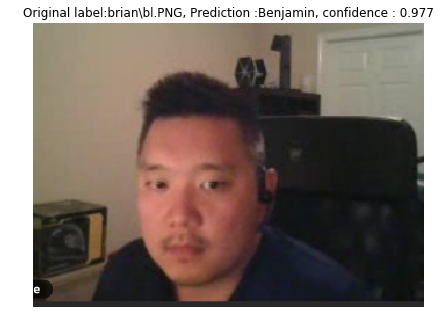

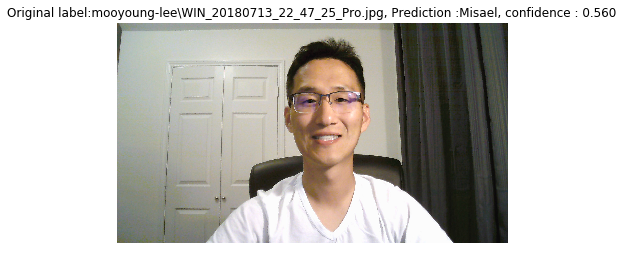

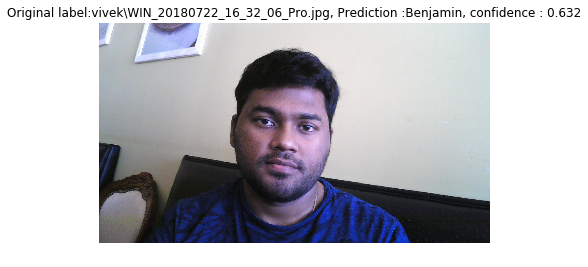

In [9]:
# from keras.preprocessing import image   # for load_image

# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)
 
# Get the filenames from the generator
fnames = validation_generator.filenames
 
# Get the ground truth from generator
ground_truth = validation_generator.classes
 
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))
 
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
     
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
     
    original = image.load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

# Google Compatible Model

In [11]:
import tensorflow as tf
model_builder = tf.saved_model.builder.SavedModelBuilder("faceID_mobile2")

inputs = {
    'input': tf.saved_model.utils.build_tensor_info(model.input)
}
outputs = {
    'earnings': tf.saved_model.utils.build_tensor_info(model.output)
}

signature_def = tf.saved_model.signature_def_utils.build_signature_def(
    inputs=inputs,
    outputs=outputs,
    method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME
)

# save structure and weight
model_builder.add_meta_graph_and_variables(
    K.get_session(),
    tags=[tf.saved_model.tag_constants.SERVING],
    signature_def_map={
        tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature_def
    }
)

model_builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'faceID_mobile2\\saved_model.pb'


b'faceID_mobile2\\saved_model.pb'